# Librares

In [61]:
import numpy as np
import math
import random
import os
import shutil
import gzip
import glob
import gc
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import tarfile
import PIL
import scipy.misc

import nibabel as nib

In [62]:
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers 
from keras import backend as K
from sklearn.model_selection import train_test_split
from scipy import ndimage as ndi


In [63]:
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K 
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, regularizers

DEVICE = "GPU"

In [64]:
# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt

# Engine

In [65]:
print(tf.__version__)
print(keras.__version__)
!nvidia-smi

2.12.0
2.12.0
Fri Oct 20 05:17:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |  16103MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                          

In [66]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

Using default strategy for CPU and single GPU
Num GPUs Available:  1
REPLICAS: 1


# Metrics

In [67]:
#intersection over union
def iou(y_true, y_pred, smooth = 0.5):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac


# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define Dice coefficient metric
def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score



# CallBacks

In [68]:
epochs = 10

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=epochs,
                          verbose=1,
                          restore_best_weights=True
                          )

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = tf.keras.callbacks.CSVLogger('Model.log')


callbacks = [earlystop, csv_logger, reduce_lr]

# Dataset

In [69]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128


In [70]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

file = tarfile.open('../input/brats-2021-task1/BraTS2021_00621.tar')

file.extractall('./sample_img')
file.close()

nSample = os.listdir('./sample_img')
nSample

['BraTS2021_00621_t1ce.nii.gz',
 'BraTS2021_00621_t1.nii.gz',
 'BraTS2021_00621_seg.nii.gz',
 'BraTS2021_00621_flair.nii.gz',
 'BraTS2021_00621_t2.nii.gz']

In [71]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [72]:
nSample = os.listdir(TRAIN_DATASET_PATH + 'BraTS2021_01261')
nSample

['BraTS2021_01261_t1ce.nii.gz',
 'BraTS2021_01261_flair.nii.gz',
 'BraTS2021_01261_t2.nii.gz',
 'BraTS2021_01261_seg.nii.gz',
 'BraTS2021_01261_t1.nii.gz']

In [73]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1.nii.gz').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t1ce.nii.gz').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_t2.nii.gz').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz').get_fdata()

Text(0.5, 1.0, 'Mask')

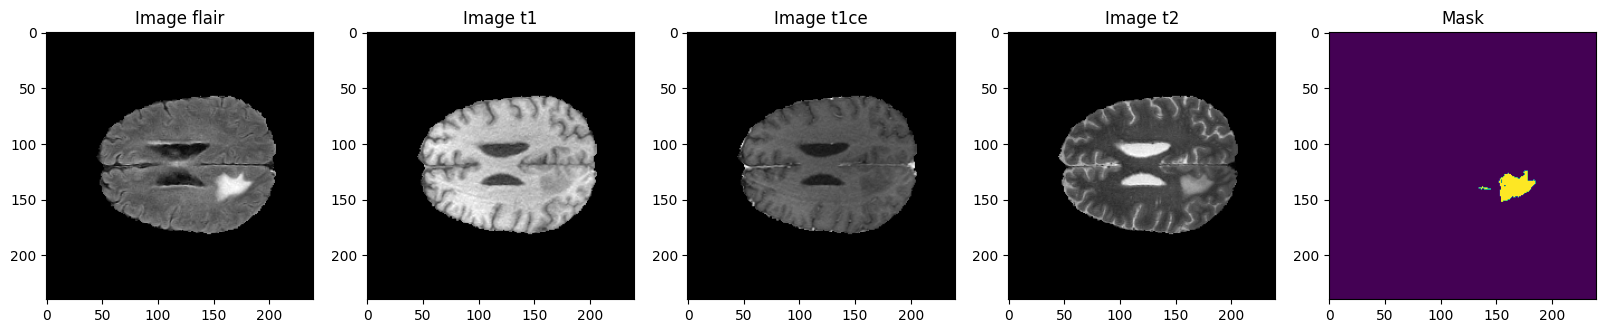

In [74]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

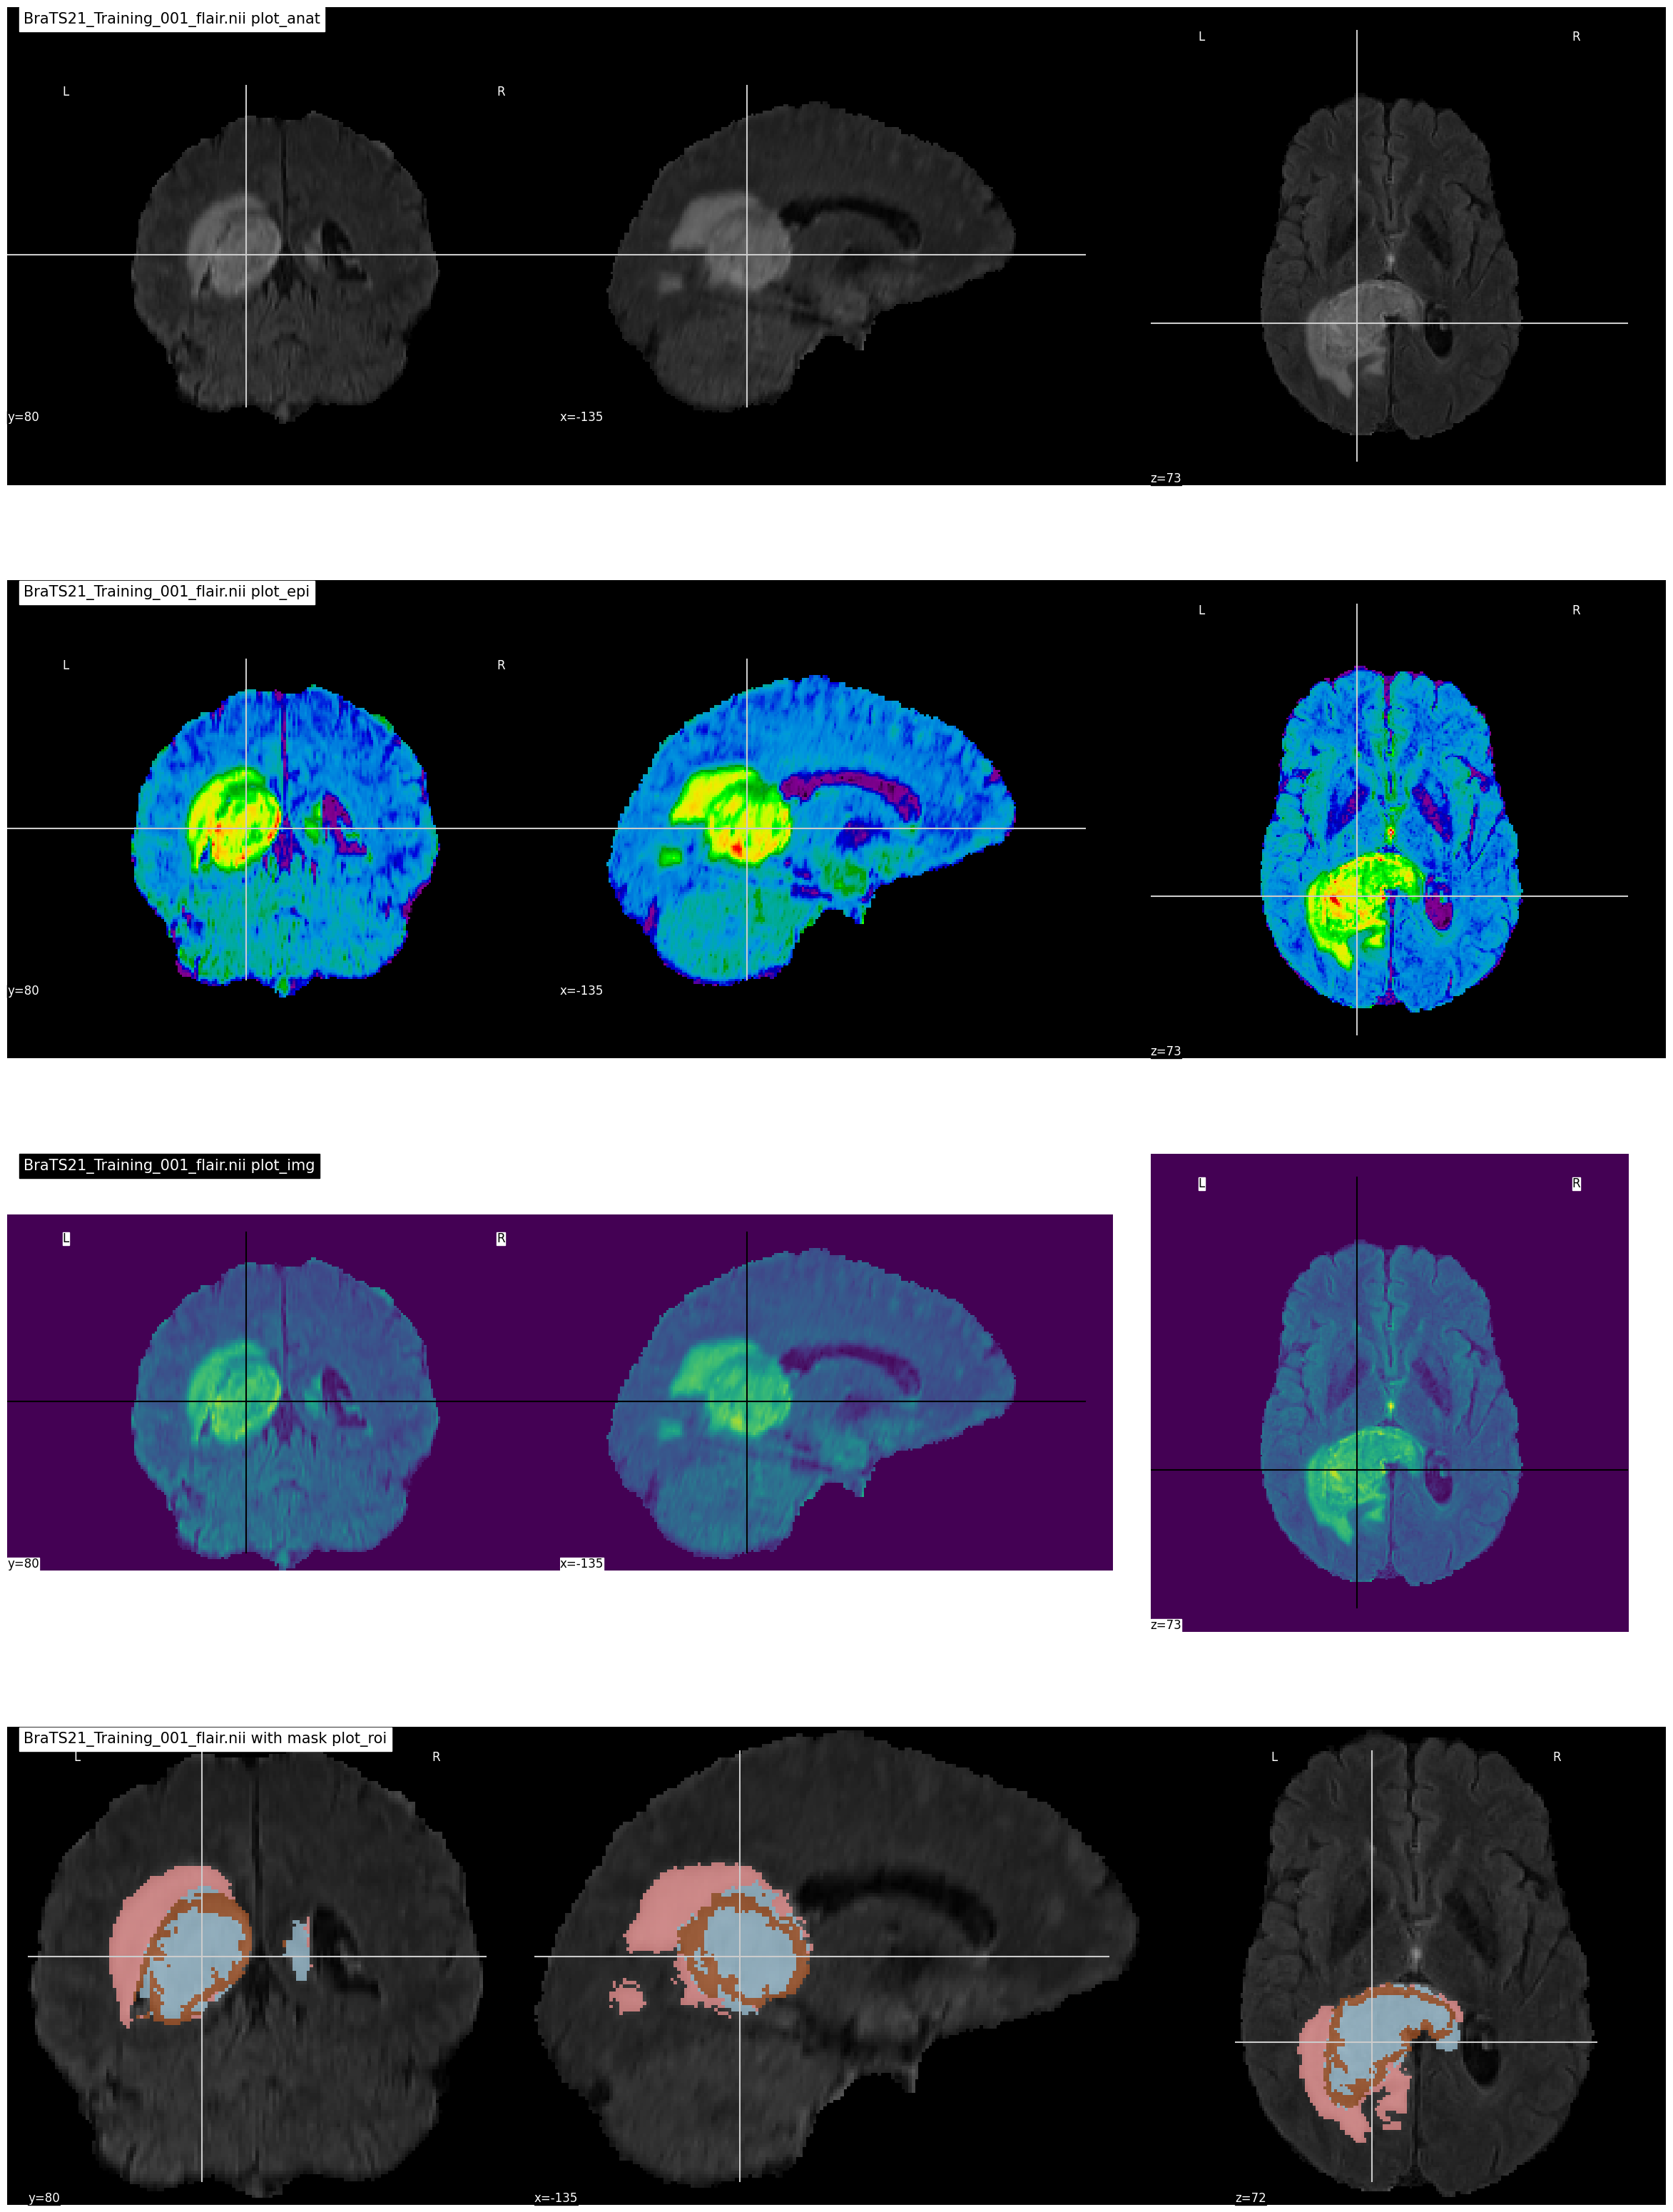

In [75]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_flair.nii.gz')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS2021_01261/BraTS2021_01261_seg.nii.gz')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS21_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS21_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS21_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS21_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [76]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

# DataGenerator & Preprocessing

# Just normalize:

In [77]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Normalize input data
        X_normalized = (X - np.mean(X)) / np.std(X)
        

        # Generate masks
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        

        return X_normalized, Y

# Create instances of the DataGenerator class
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

# With tensorflow-Augment

In [114]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

        # Find list of IDs
        batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)


    def __data_generation(self, batch_ids):
        'Generates data containing batch_size samples' # X: (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii.gz')
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii.gz')
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii.gz')
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Normalize input data
        X_normalized = (X - np.mean(X)) / np.std(X)
        
        # Convert labels to one-hot encoding
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        mask_resized = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))

        # Apply data augmentation on-the-fly
        augmented_images = []
        augmented_masks = []
        for i in range(X_normalized.shape[0]):
            augmented_images.append(tf.image.random_flip_left_right(X_normalized[i]))
            augmented_masks.append(tf.image.random_flip_left_right(mask_resized[i]))
            
            augmented_images.append(tf.image.random_brightness(X_normalized[i], 0.2))
            augmented_masks.append(tf.image.random_brightness(mask_resized[i], 0.2))
            
            augmented_images.append(tf.image.random_contrast(X_normalized[i], 0.2, 0.5))
            augmented_masks.append(tf.image.random_contrast(mask_resized[i], 0.2, 0.5))
        
        augmented_images = tf.stack(augmented_images)
        augmented_masks = tf.stack(augmented_masks)

        return augmented_images, augmented_masks

# Create instances of the DataGenerator class
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


850
251
150


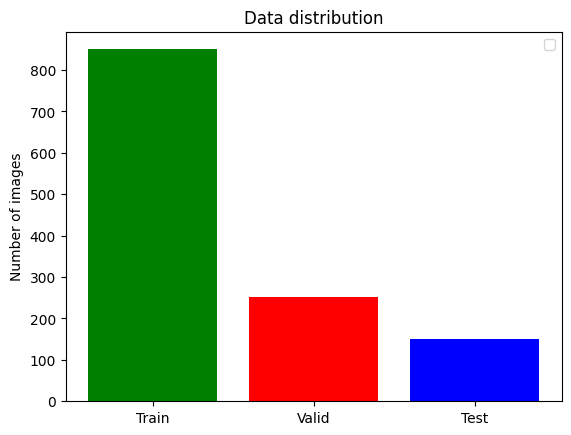

In [78]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()

print(len(train_ids))
print(len(val_ids))
print(len(test_ids))
showDataLayout()


# Model

In [94]:
#from keras.layers.advanced_activations import ELU
from keras.layers import ELU, PReLU, LeakyReLU

In [80]:
from keras.applications import ResNet50

# Resnet-50 pretrained model as encoder with advanced ELUBridge-Net++ as decoder

In [96]:
def model0(input_shape):
    
    # duplicate and concatenate the input channels
    input_channels = Input(shape=input_shape)
    duplicated_channels = concatenate([input_channels, input_channels], axis=-1)
    
    # Encoder (ResNet50)
    base_model = ResNet50(input_tensor=duplicated_channels, include_top=False, weights=None)
    
    # Freeze the layers in the base model
    #for layer in base_model.layers:
        #layer.trainable = False
        
    encoder_output = base_model.get_layer('conv4_block6_out').output

    # Decoder
    skip_connections = base_model.get_layer('conv3_block4_out').output
    
    # Bridge
    bridge = layers.Conv2D(256, 3, activation='ELU', padding='same')(encoder_output)
    bridge = layers.BatchNormalization()(bridge)
    bridge = layers.Conv2D(256, 3, activation='ELU', padding='same')(bridge)
    bridge = layers.BatchNormalization()(bridge)

    # Decoder 
    up1 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(bridge)
    up1 = layers.concatenate([up1, skip_connections])
    up1 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    up1 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    up1 = layers.BatchNormalization()(up1)
    
    up2 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(up1)
    skip2_connections = base_model.get_layer('conv2_block3_out').output
    up2 = layers.concatenate([up2, skip2_connections])
    up2 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)
    up2 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    up2 = layers.BatchNormalization()(up2)

    up3 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(up2)
    skip3_connections = base_model.get_layer('conv1_relu').output
    up3 = layers.concatenate([up3, skip3_connections])
    up3 = layers.Conv2D(32, 3, activation='relu', padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    up3 = layers.Conv2D(32, 3, activation='relu', padding='same')(up3)
    up3 = layers.BatchNormalization()(up3)
    
    # Upsample to the desired output size
    up4 = layers.UpSampling2D((2, 2))(up3)

    # Output
    output = layers.Conv2D(4, 1, activation="softmax")(up4)

    # Create and compile the model
    model = Model(inputs=input_channels, outputs=output)
    
    return model

In [97]:
input_shape = (IMG_SIZE, IMG_SIZE, 2)  # Adjust the number of channels according to the data

model = model0(input_shape)
model.compile(loss = "categorical_crossentropy",
            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07), 
              
            metrics = (['accuracy', tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='AUC'),
                        f1_score, specificity, sensitivity, iou, dice_coefficient]))

print(model.input_shape)
print(model.output_shape)
model.summary()

(None, 128, 128, 2)
(None, 128, 128, 4)
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 128, 128, 2  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_45 (Concatenate)   (None, 128, 128, 4)  0           ['input_13[0][0]',               
                                                                  'input_13[0][0]']               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 4)  0           ['concatenate_45[0][0]']         
                                                   

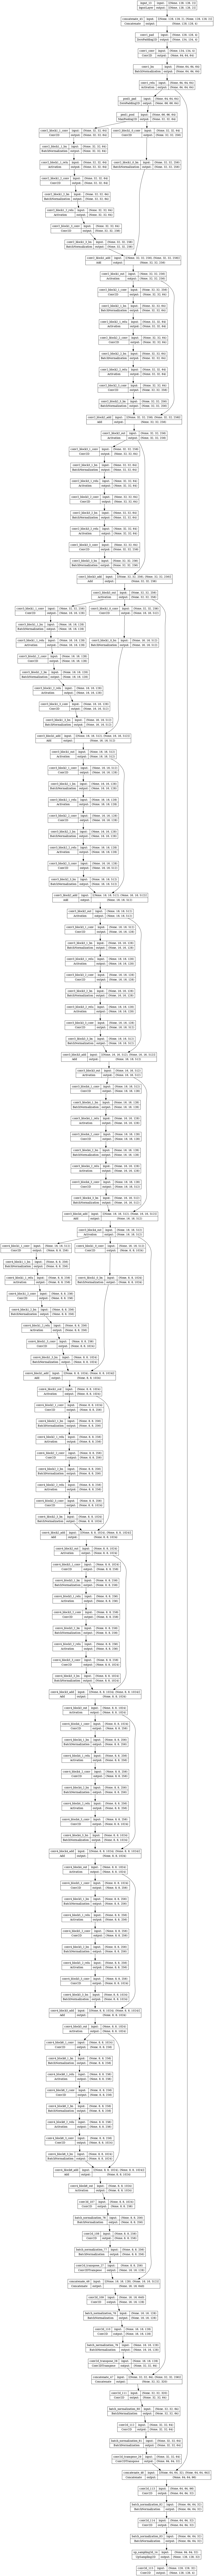

In [98]:
tf.keras.utils.plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

# Train 

# With preprocces

In [115]:
%%time
history =  model.fit(training_generator,
                        epochs = 10,
                        steps_per_epoch=len(train_ids),
                        callbacks = callbacks ,
                        validation_data = valid_generator) 

Epoch 1/10
850/850 [==============================] - 1519s 2s/step - loss: 0.0598 - accuracy: 0.9913 - precision: 0.9961 - recall: 0.4063 - AUC: 0.7211 - f1_score: 0.9894 - specificity: 0.9971 - sensitivity: 0.9881 - iou: 0.9595 - dice_coefficient: 0.9793 - val_loss: 0.3389 - val_accuracy: 0.9858 - val_precision: 0.9936 - val_recall: 0.4078 - val_AUC: 0.7237 - val_f1_score: 0.9839 - val_specificity: 0.9952 - val_sensitivity: 0.9828 - val_iou: 0.9433 - val_dice_coefficient: 0.9703 - lr: 2.0000e-04
Epoch 2/10
850/850 [==============================] - 1504s 2s/step - loss: 0.0563 - accuracy: 0.9914 - precision: 0.9962 - recall: 0.4063 - AUC: 0.7279 - f1_score: 0.9890 - specificity: 0.9971 - sensitivity: 0.9876 - iou: 0.9581 - dice_coefficient: 0.9785 - val_loss: 0.0635 - val_accuracy: 0.9888 - val_precision: 0.9950 - val_recall: 0.4084 - val_AUC: 0.7246 - val_f1_score: 0.9870 - val_specificity: 0.9962 - val_sensitivity: 0.9860 - val_iou: 0.9513 - val_dice_coefficient: 0.9748 - lr: 2.000

In [116]:
model.save("Model.h5")
print('Model save to Disk')

Model save to Disk


In [117]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size = 16, callbacks = callbacks)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 176s 1s/step - loss: 0.0676 - accuracy: 0.9887 - precision: 0.9956 - recall: 0.4027 - AUC: 0.7181 - f1_score: 0.9868 - specificity: 0.9967 - sensitivity: 0.9842 - iou: 0.9512 - dice_coefficient: 0.9748
test loss, test acc: [0.06762251257896423, 0.9886650443077087, 0.9956070780754089, 0.4026581645011902, 0.7180567979812622, 0.9868027567863464, 0.9967166185379028, 0.9842143654823303, 0.9511602520942688, 0.9748005270957947]
CPU times: user 2min 32s, sys: 41.3 s, total: 3min 13s
Wall time: 2min 56s


# Result

In [118]:
import pandas as pd
df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
#df.to_csv("output.csv")
df.head(30)

loss  accuracy  precision    recall       AUC  f1_score  specificity  \
0  0.059776  0.991262   0.996150  0.406318  0.721080  0.989420     0.997100   
1  0.056322  0.991405   0.996216  0.406281  0.727950  0.989012     0.997090   
2  0.055985  0.991365   0.996321  0.406205  0.729688  0.988922     0.997130   
3  0.055730  0.991444   0.996448  0.406149  0.731030  0.988882     0.997173   
4  0.049060  0.991559   0.996522  0.405987  0.731284  0.988911     0.997271   
5  0.052197  0.991297   0.996451  0.405826  0.722271  0.988849     0.997243   
6  0.055733  0.991339   0.996530  0.405706  0.717926  0.988867     0.997357   
7  0.054599  0.991514   0.996762  0.405573  0.714425  0.988975     0.997519   
8  0.053347  0.991486   0.996847  0.405499  0.713864  0.989003     0.997568   
9  0.050356  0.991406   0.996852  0.405467  0.713053  0.989004     0.997579   

   sensitivity       iou  dice_coefficient  ...  val_accuracy  val_precision  \
0     0.988054  0.959538          0.979275  ...      0.985792       0.993594   
1     0.987565  0.958129          0.978545  ...      0.988832       0.994990   
2     0.987338  0.957412          0.978170  ...      0.988564       0.994882   
3     0.987167  0.957295          0.978103  ...      0.989040       0.994962   
4     0.986962  0.958162          0.978550  ...      0.988182       0.994702   
5     0.986738  0.958549          0.978755  ...      0.989006       0.995239   
6     0.986573  0.957610          0.978267  ...      0.988510       0.995307   
7     0.986402  0.957911          0.978417  ...      0.988483       0.995352   
8     0.986301  0.957636          0.978280  ...      0.988918       0.995638   
9     0.986259  0.957943          0.978431  ...      0.989103       0.995824   

   val_recall   val_AUC  val_f1_score  val_specificity  val_sensitivity  \
0    0.407801  0.723738      0.983915         0.995204         0.982801   
1    0.408428  0.724562      0.987030         0.996243         0.985991   
2    0.408303  0.725742      0.986645         0.996190         0.985506   
3    0.408551  0.723341      0.987245         0.996280         0.986373   
4    0.408071  0.721263      0.987148         0.996314         0.985822   
5    0.408314  0.724313      0.987584         0.996514         0.986283   
6    0.407638  0.719335      0.987067         0.996607         0.984927   
7    0.407449  0.718308      0.987007         0.996685         0.984611   
8    0.407537  0.718724      0.987371         0.996826         0.984943   
9    0.407536  0.718994      0.987538         0.996913         0.985020   

    val_iou  val_dice_coefficient       lr  
0  0.943342              0.970349  0.00020  
1  0.951349              0.974840  0.00020  
2  0.949572              0.973892  0.00020  
3  0.952756              0.975577  0.00020  
4  0.953439              0.975961  0.00020  
5  0.954677              0.976629  0.00020  
6  0.951108              0.974726  0.00020  
7  0.951673              0.975010  0.00004  
8  0.952429              0.975436  0.00004  
9  0.952093              0.975272  0.00004  

[10 rows x 21 columns]

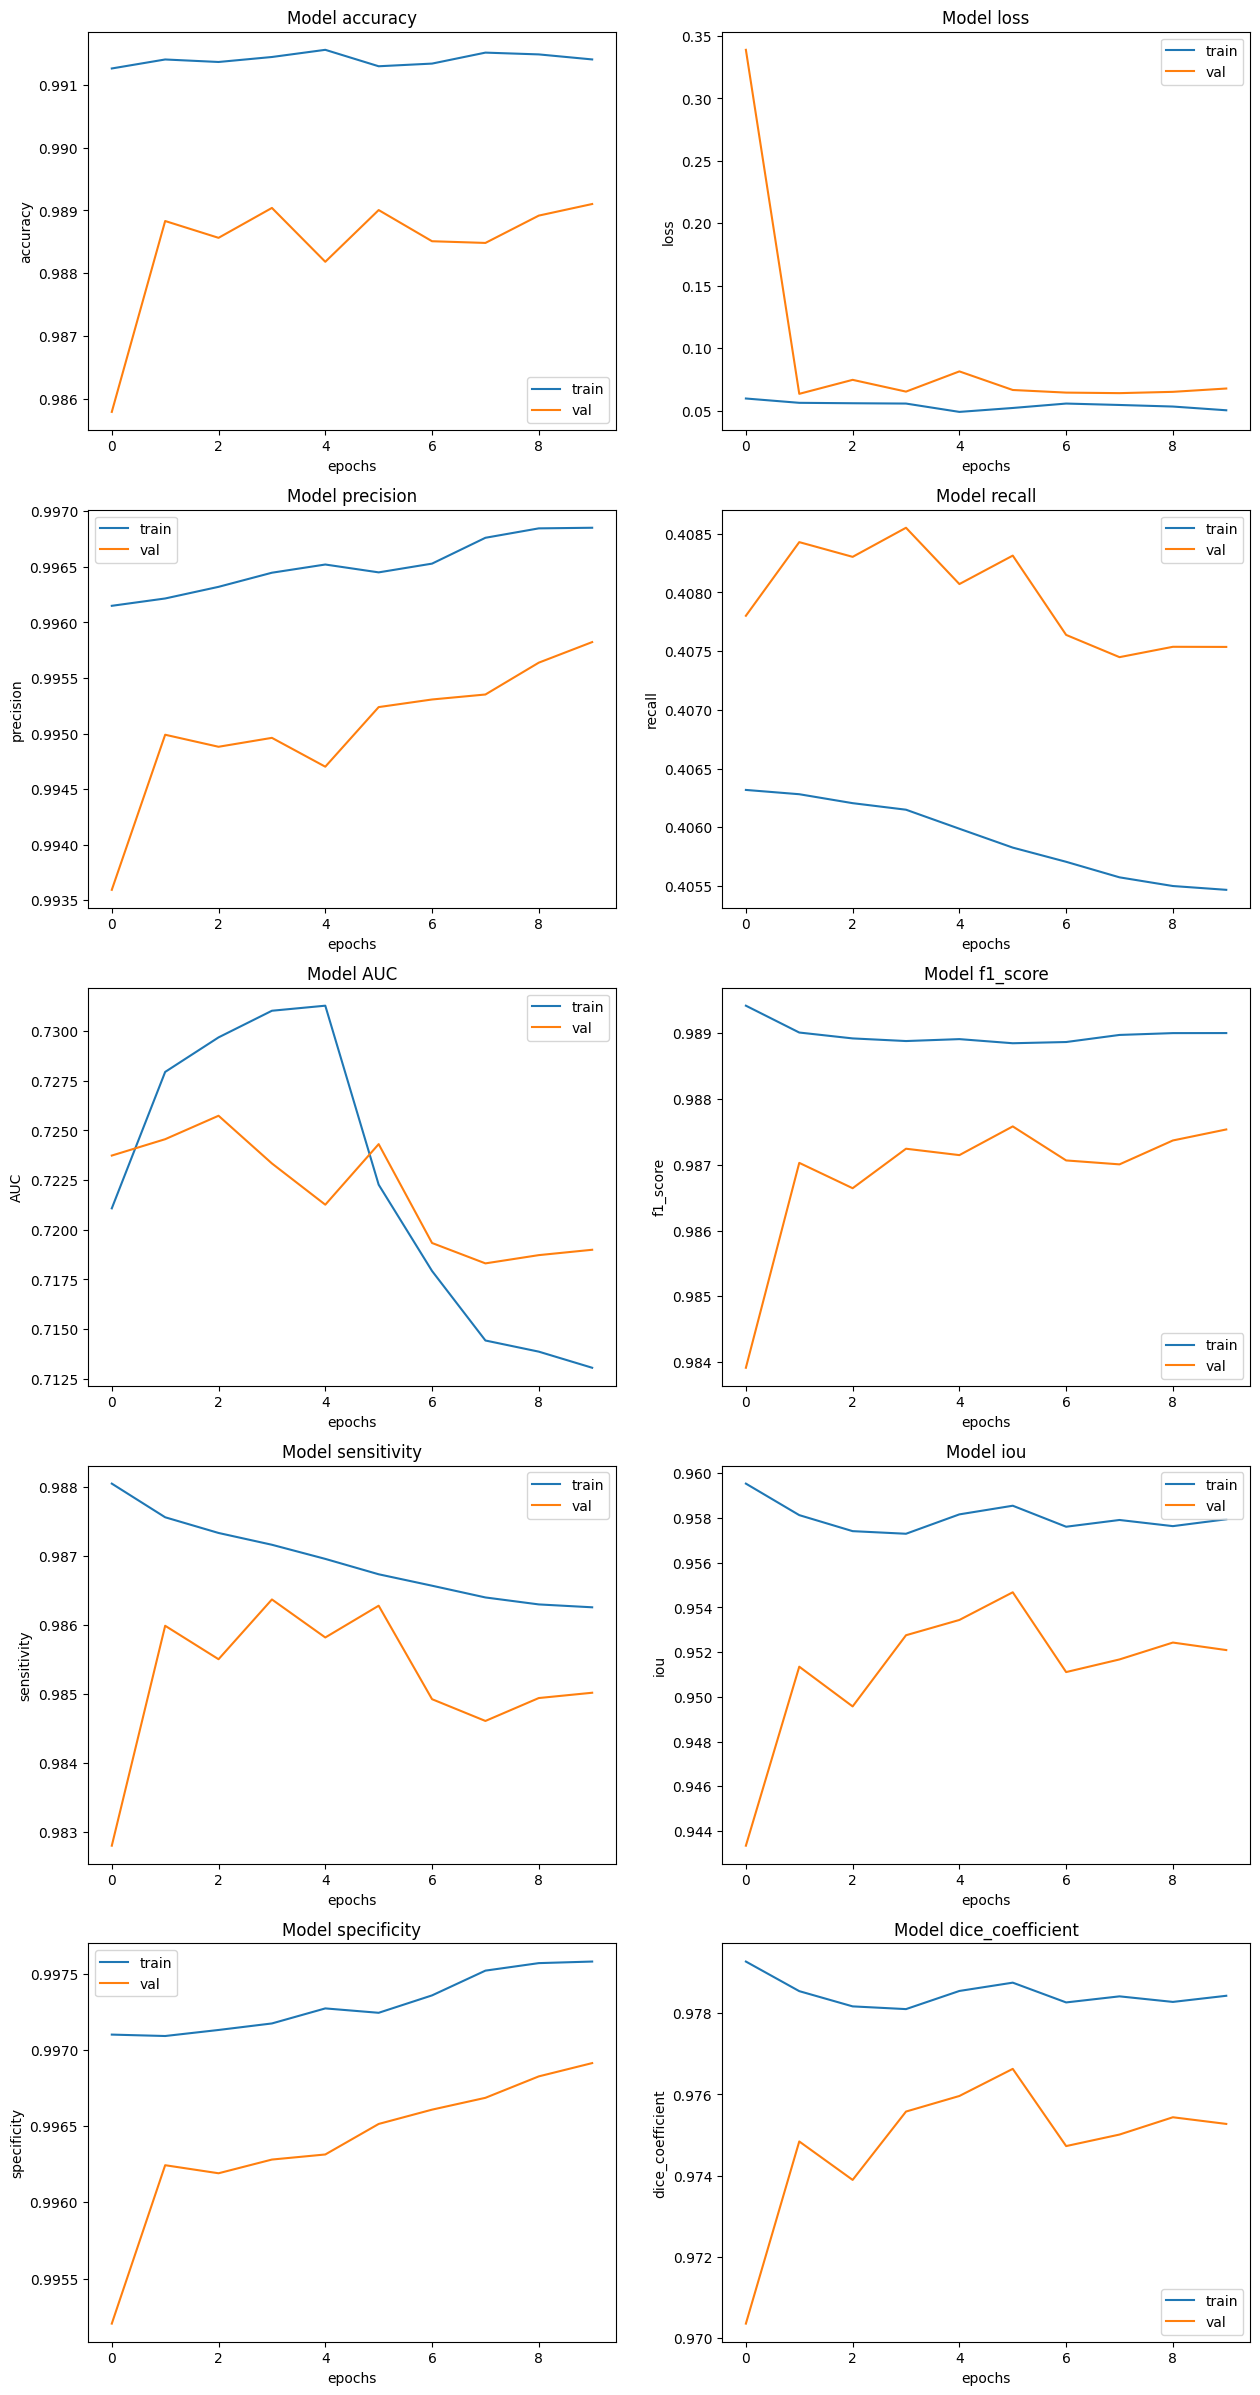

In [119]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC','f1_score', 'sensitivity', 'iou','specificity','dice_coefficient' ]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

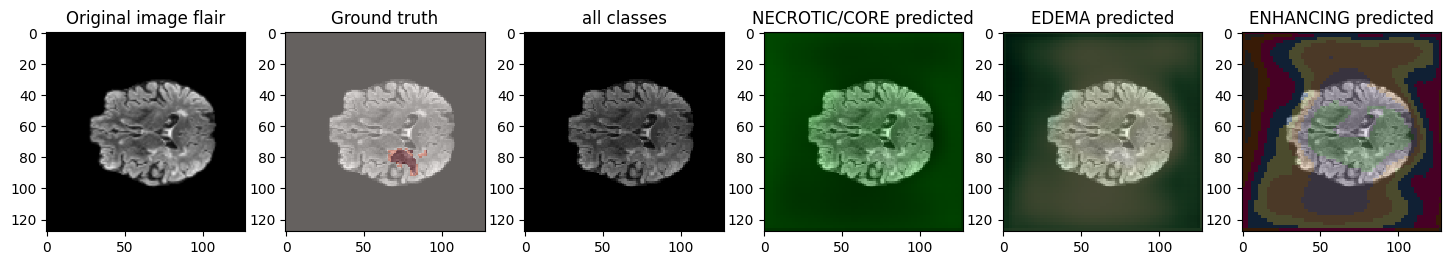

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

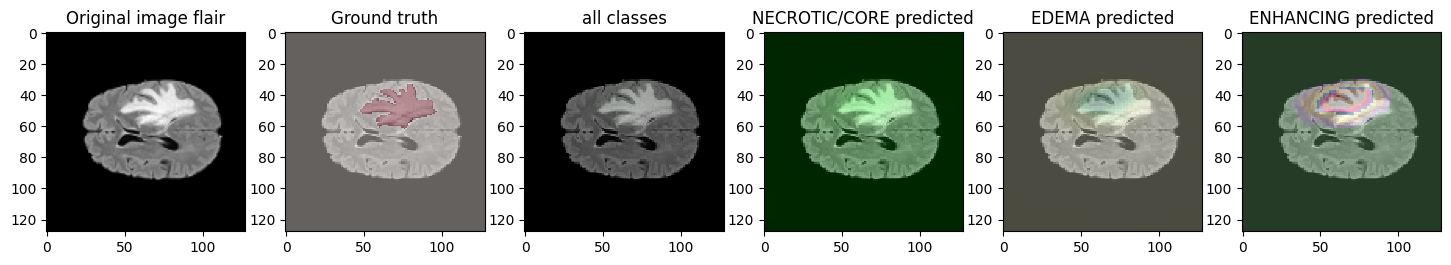

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

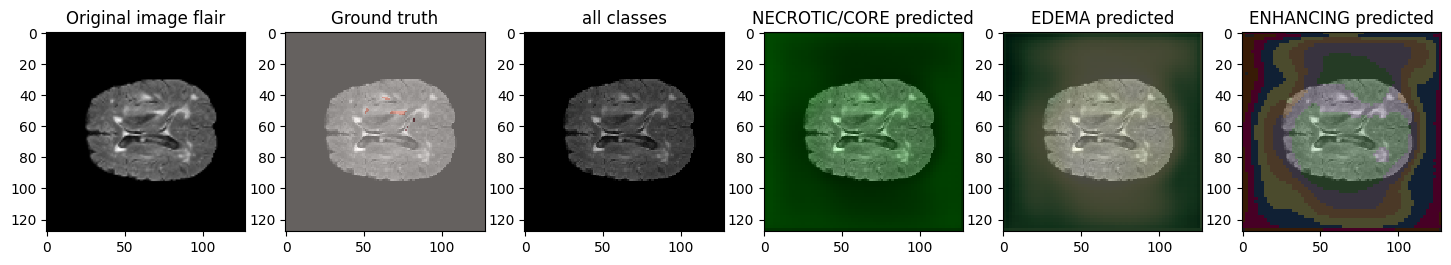

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

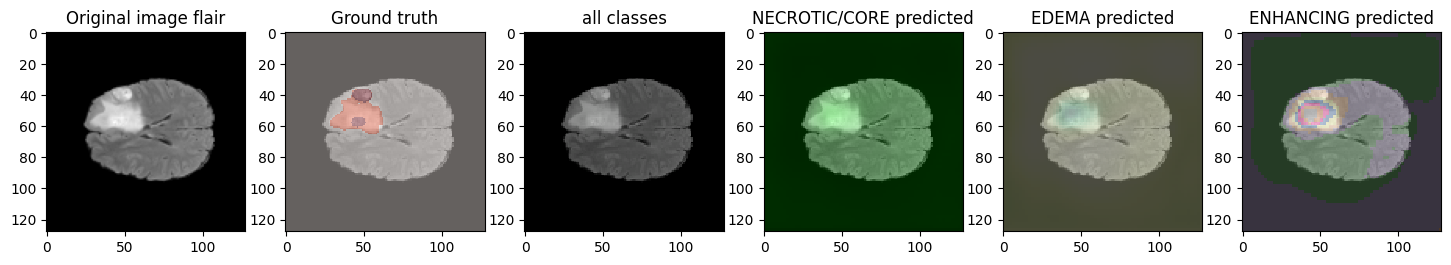

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

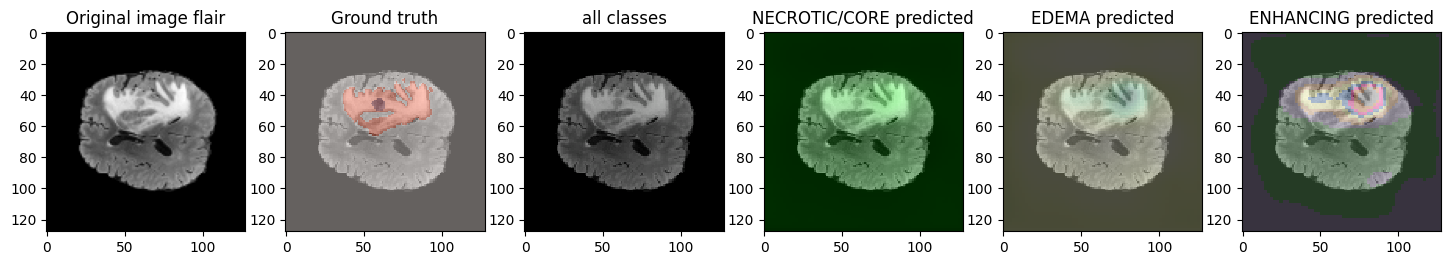

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

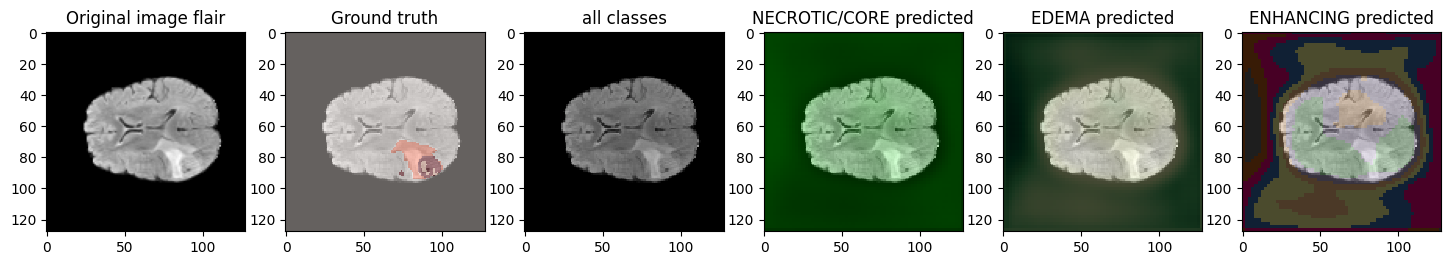

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

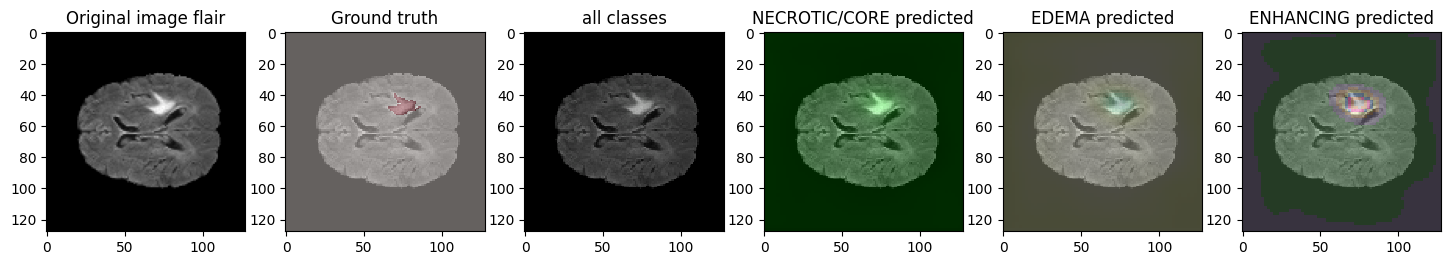

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

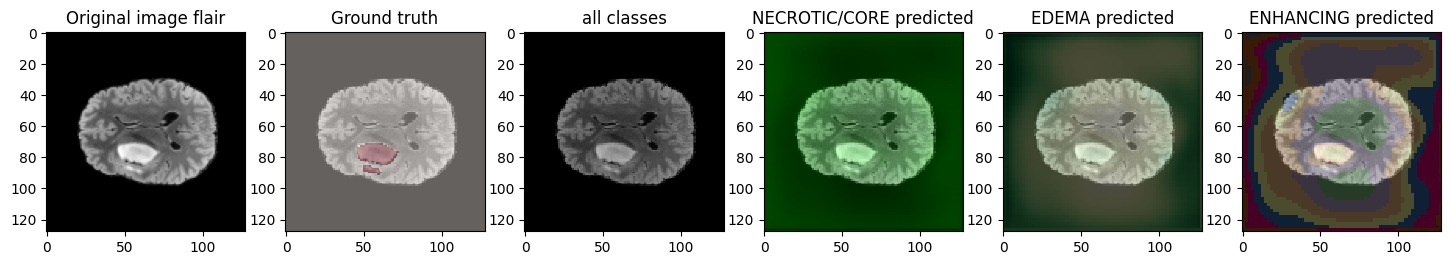

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

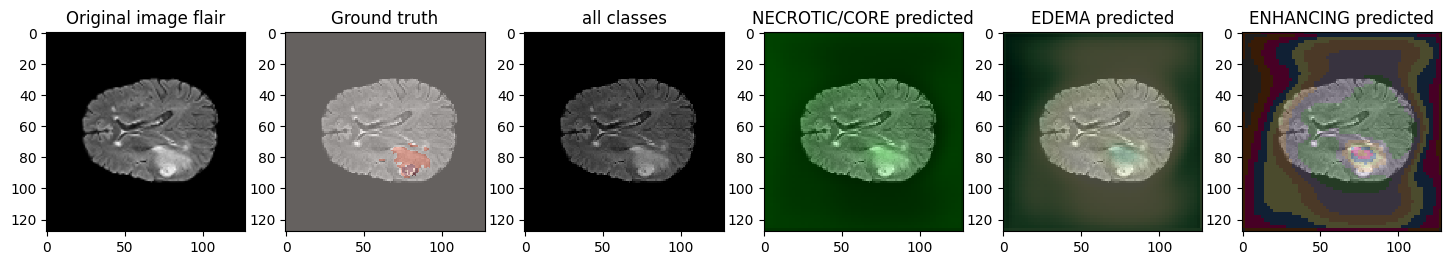

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

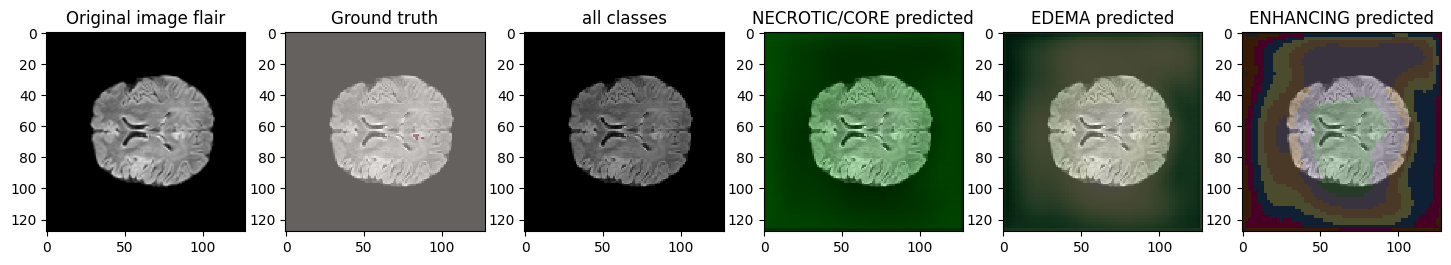

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

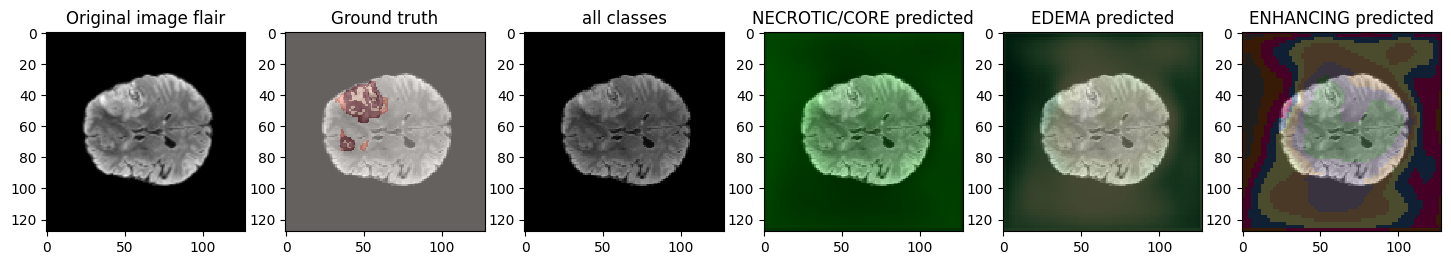

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

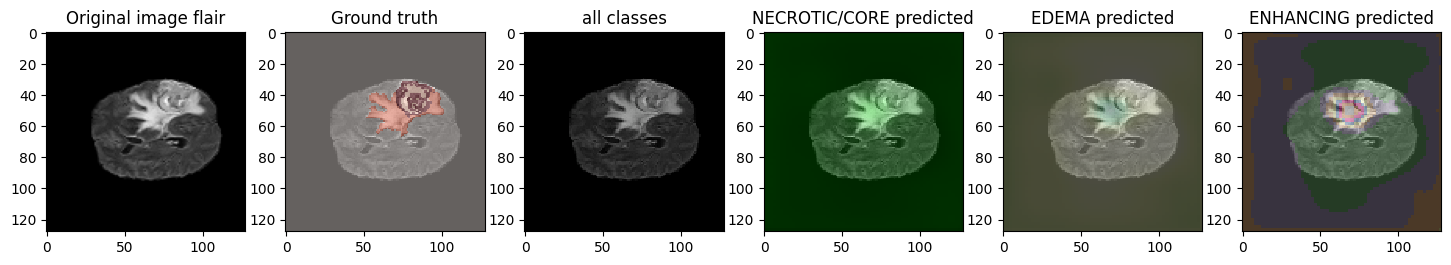

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

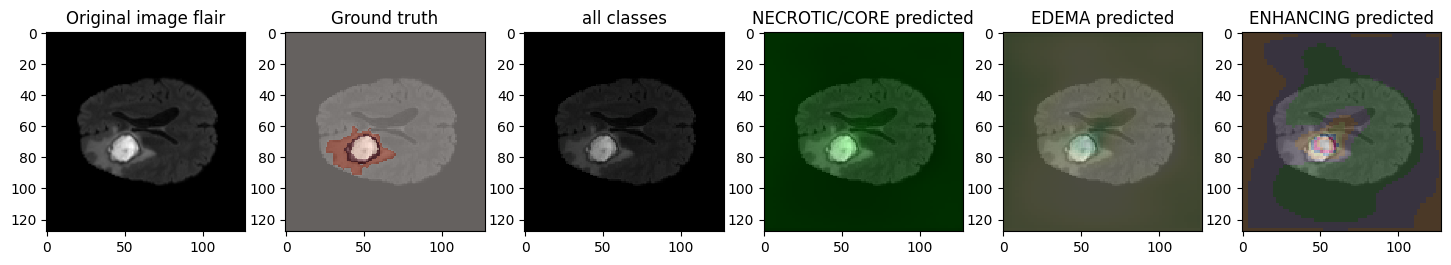

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

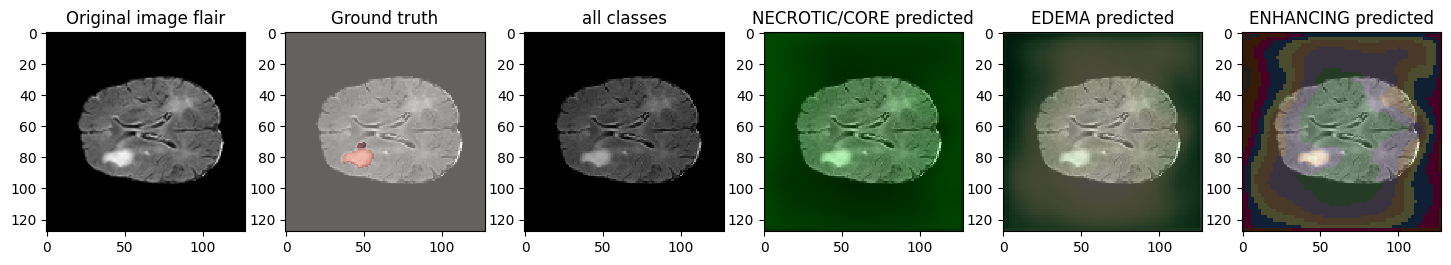

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

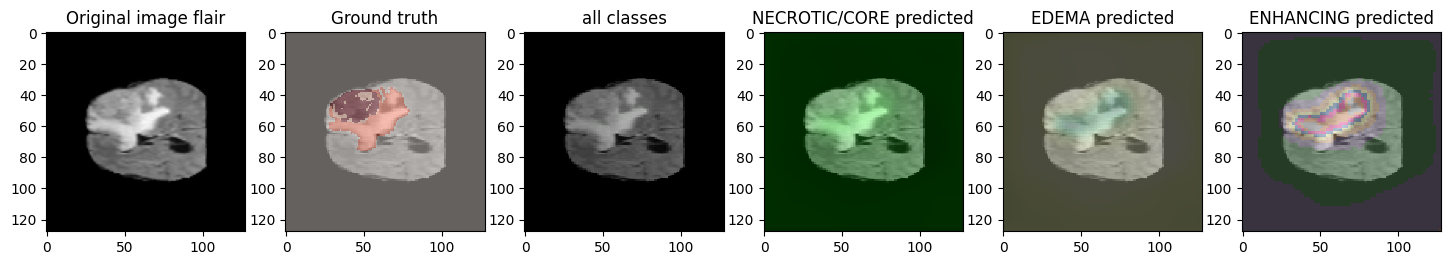

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

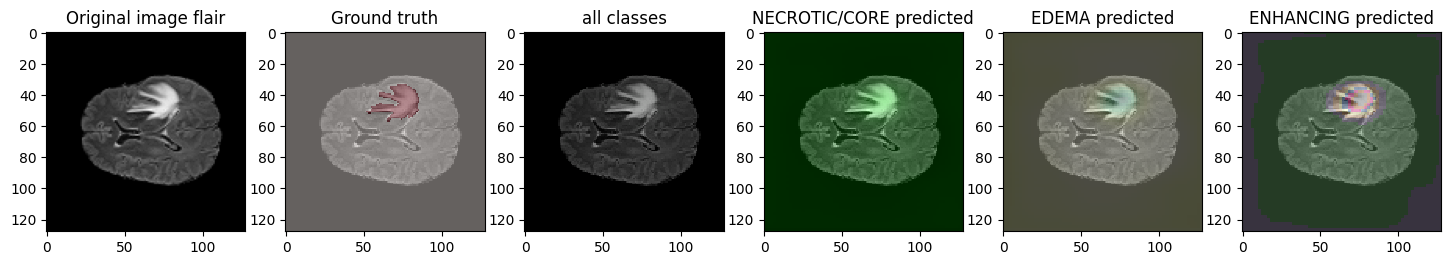

In [120]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

   # /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    vol_path = case_path + case + '_flair.nii.gz';
    flair=nib.load(vol_path).get_fdata()
    
    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    vol_path = case_path + case + '_t1ce.nii.gz';
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + case + '/'

    # TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

    gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
    origImage = nib.load(path + case +'_flair.nii.gz').get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.4) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Blues", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="green_transparent", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="YlGn", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="Accent", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])
showPredictsById(case=test_ids[7])
showPredictsById(case=test_ids[8])
showPredictsById(case=test_ids[9])
showPredictsById(case=test_ids[10])
showPredictsById(case=test_ids[11])
showPredictsById(case=test_ids[12])
showPredictsById(case=test_ids[13])
showPredictsById(case=test_ids[14])
showPredictsById(case=test_ids[15])

# Train

# Without preprocces

In [99]:
%%time
history0 =  model.fit(training_generator,
                        epochs = 10,
                        steps_per_epoch=len(train_ids),
                        callbacks = callbacks ,
                        validation_data = valid_generator) 

Epoch 1/10
850/850 [==============================] - 533s 589ms/step - loss: 0.2301 - accuracy: 0.9685 - precision: 0.9892 - recall: 0.8762 - AUC: 0.9942 - f1_score: 0.9013 - specificity: 0.9962 - sensitivity: 0.8787 - iou: 0.7855 - dice_coefficient: 0.8552 - val_loss: 0.1510 - val_accuracy: 0.9569 - val_precision: 0.9669 - val_recall: 0.9469 - val_AUC: 0.9947 - val_f1_score: 0.9566 - val_specificity: 0.9886 - val_sensitivity: 0.9492 - val_iou: 0.8840 - val_dice_coefficient: 0.9347 - lr: 0.0010
Epoch 2/10
850/850 [==============================] - 506s 595ms/step - loss: 0.0380 - accuracy: 0.9881 - precision: 0.9928 - recall: 0.9821 - AUC: 0.9995 - f1_score: 0.9881 - specificity: 0.9970 - sensitivity: 0.9849 - iou: 0.9615 - dice_coefficient: 0.9803 - val_loss: 0.1843 - val_accuracy: 0.9550 - val_precision: 0.9580 - val_recall: 0.9511 - val_AUC: 0.9923 - val_f1_score: 0.9549 - val_specificity: 0.9855 - val_sensitivity: 0.9534 - val_iou: 0.9141 - val_dice_coefficient: 0.9518 - lr: 0.001

In [100]:
model.save("Model-0.h5")
print('Model save to Disk')

Model save to Disk


In [101]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size = 16, callbacks = callbacks)
print("test loss, test acc:", results)

Evaluate on test data
150/150 [==============================] - 71s 475ms/step - loss: 0.2254 - accuracy: 0.9709 - precision: 0.9759 - recall: 0.9659 - AUC: 0.9921 - f1_score: 0.9714 - specificity: 0.9914 - sensitivity: 0.9688 - iou: 0.9400 - dice_coefficient: 0.9679
test loss, test acc: [0.22538471221923828, 0.9708637595176697, 0.9759356379508972, 0.9659111499786377, 0.9921064376831055, 0.9714345335960388, 0.9914391040802002, 0.9687955975532532, 0.9399898052215576, 0.9678907990455627]
CPU times: user 53.9 s, sys: 22.8 s, total: 1min 16s
Wall time: 1min 11s


# Results

In [102]:
import pandas as pd
df = pd.DataFrame(history0.history) 
df.to_excel("output-0.xlsx")
#df.to_csv("output1.csv")
df.head(30)

loss  accuracy  precision    recall       AUC  f1_score  specificity  \
0  0.230090  0.968533   0.989234  0.876247  0.994197  0.901284     0.996237   
1  0.038006  0.988070   0.992846  0.982137  0.999505  0.988075     0.997023   
2  0.033967  0.989016   0.993183  0.983612  0.999518  0.988913     0.997122   
3  0.033459  0.989113   0.993040  0.983994  0.999520  0.988995     0.997069   
4  0.031530  0.989519   0.993428  0.984450  0.999551  0.989386     0.997181   
5  0.029514  0.990116   0.993795  0.985347  0.999567  0.989969     0.997292   
6  0.027170  0.990719   0.994228  0.986096  0.999626  0.990502     0.997420   
7  0.026154  0.991097   0.994499  0.986496  0.999633  0.990824     0.997503   
8  0.025273  0.991385   0.994593  0.986981  0.999642  0.991084     0.997528   
9  0.024266  0.991711   0.994774  0.987496  0.999650  0.991401     0.997582   

   sensitivity       iou  dice_coefficient  ...  val_accuracy  val_precision  \
0     0.878695  0.785544          0.855184  ...      0.956895       0.966913   
1     0.984891  0.961508          0.980327  ...      0.954986       0.958030   
2     0.986295  0.967018          0.983194  ...      0.962183       0.973592   
3     0.986638  0.968187          0.983801  ...      0.867622       0.875076   
4     0.987063  0.969654          0.984559  ...      0.968357       0.975107   
5     0.987913  0.971670          0.985599  ...      0.962287       0.971027   
6     0.988604  0.973147          0.986360  ...      0.944490       0.948274   
7     0.988991  0.974039          0.986820  ...      0.970624       0.978893   
8     0.989446  0.974970          0.987296  ...      0.971457       0.974318   
9     0.989929  0.975928          0.987787  ...      0.966440       0.971810   

   val_recall   val_AUC  val_f1_score  val_specificity  val_sensitivity  \
0    0.946917  0.994669      0.956614         0.988595         0.949245   
1    0.951089  0.992275      0.954880         0.985504         0.953449   
2    0.955009  0.996538      0.964168         0.990774         0.957415   
3    0.862253  0.934029      0.868670         0.958291         0.864398   
4    0.963151  0.995643      0.969337         0.991207         0.965591   
5    0.957175  0.992612      0.964174         0.989870         0.959597   
6    0.939924  0.975376      0.944360         0.982268         0.942225   
7    0.965272  0.995856      0.972243         0.992446         0.967656   
8    0.967822  0.992463      0.971370         0.990876         0.970181   
9    0.961661  0.990676      0.967152         0.990148         0.964226   

    val_iou  val_dice_coefficient     lr  
0  0.883964              0.934705  0.001  
1  0.914063              0.951800  0.001  
2  0.921746              0.956940  0.001  
3  0.783170              0.862678  0.001  
4  0.935539              0.964970  0.001  
5  0.923030              0.957341  0.001  
6  0.893431              0.939694  0.001  
7  0.937867              0.966633  0.001  
8  0.941188              0.968289  0.001  
9  0.932692              0.963486  0.001  

[10 rows x 21 columns]

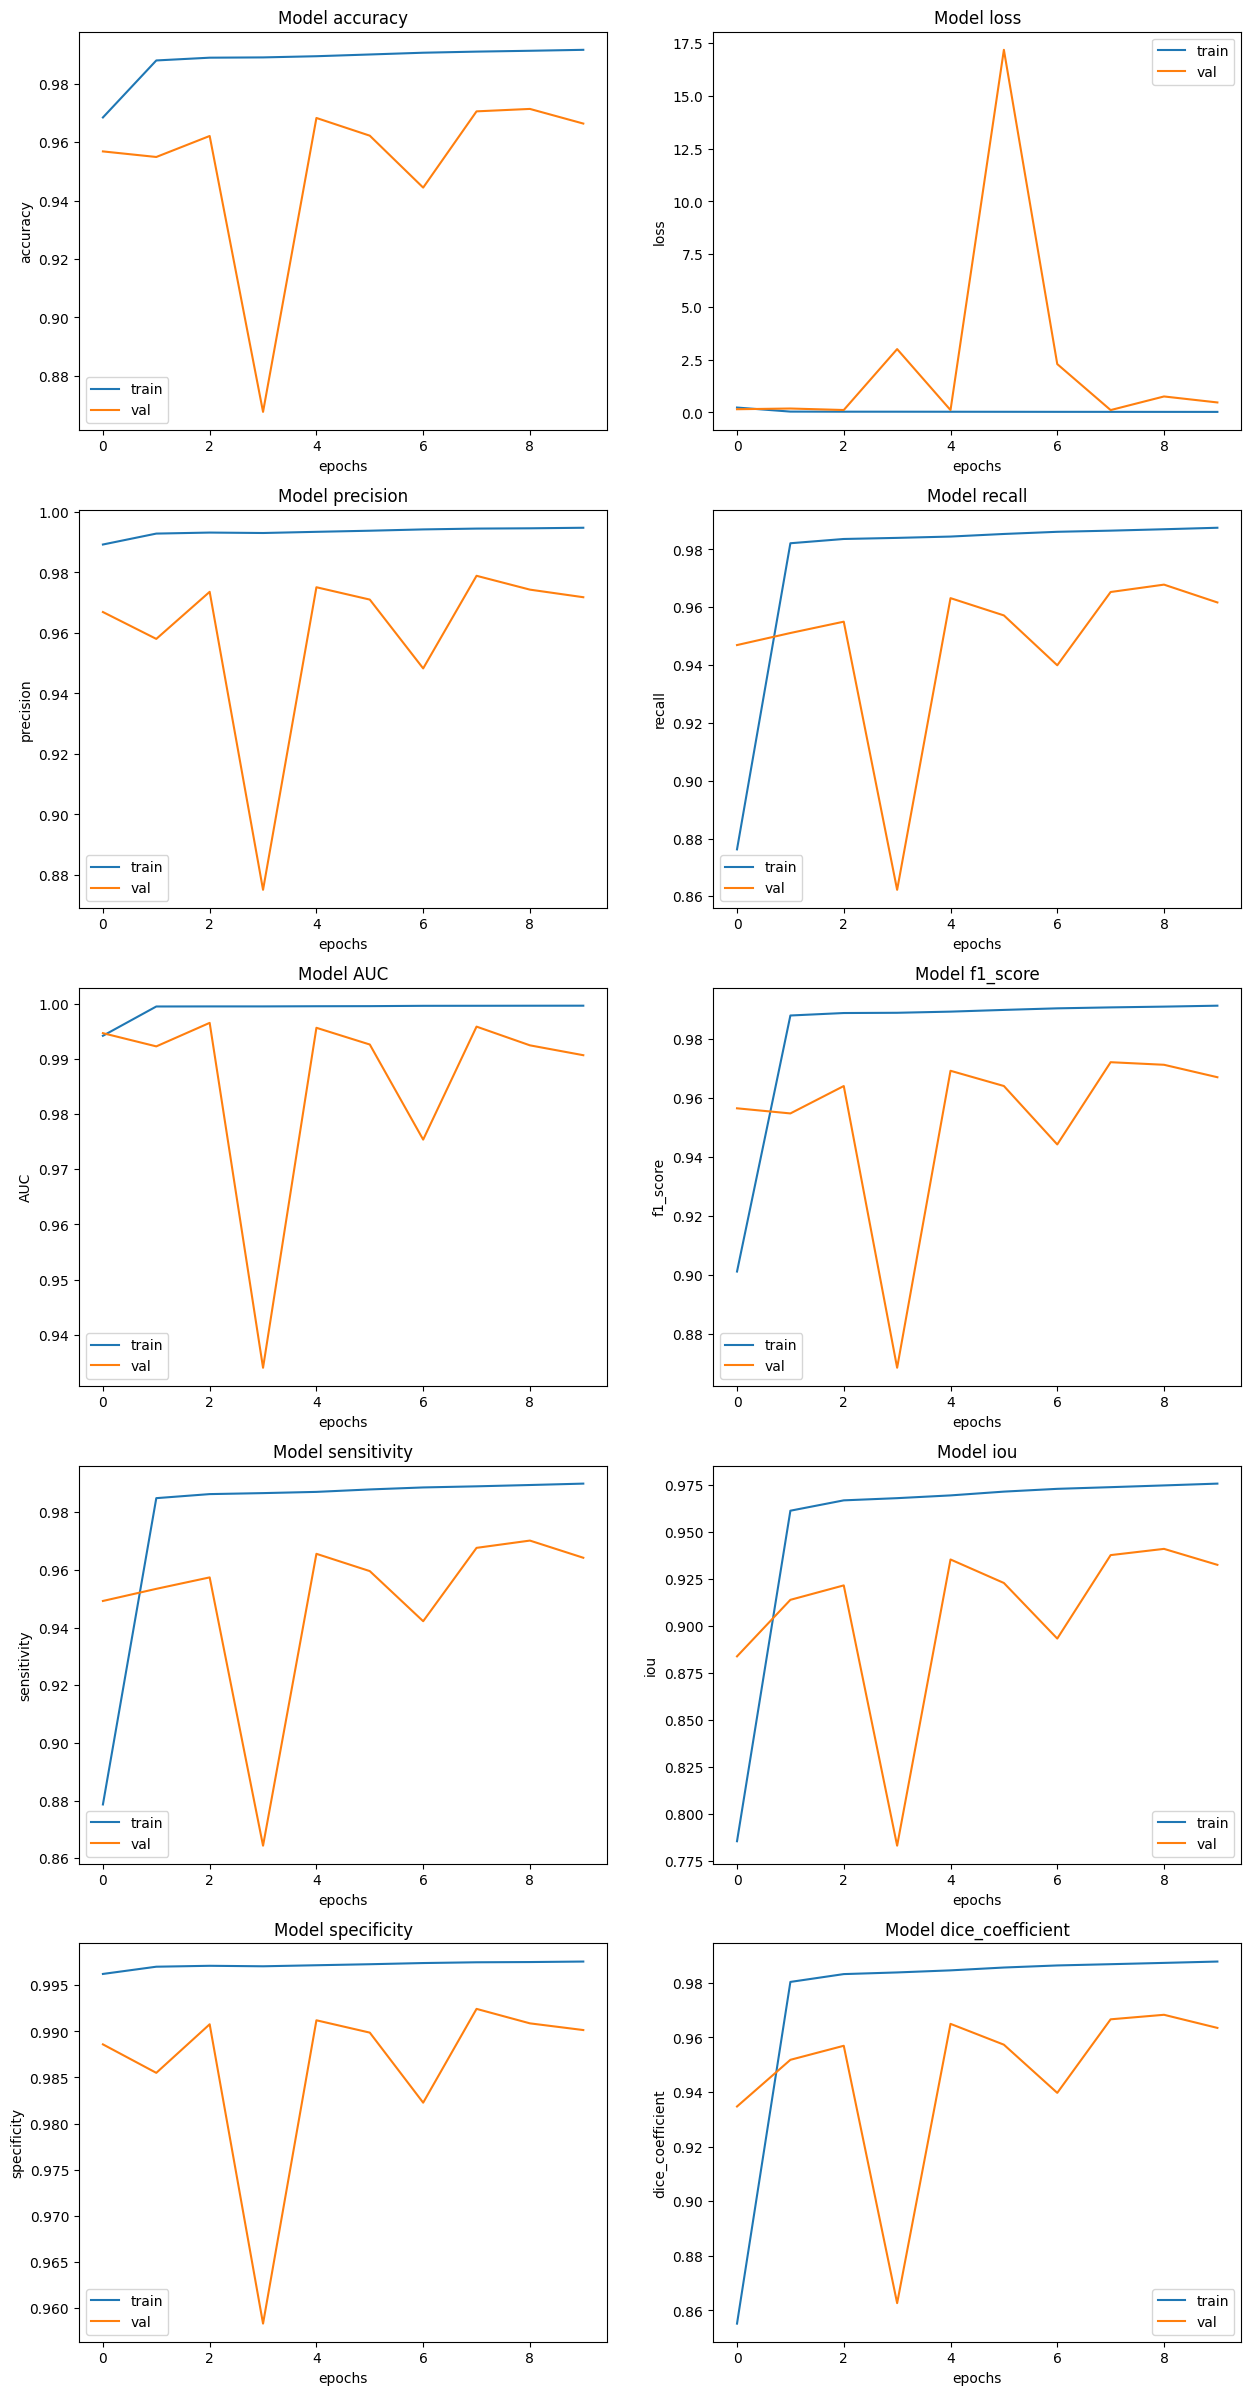

In [103]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC','f1_score', 'sensitivity', 'iou','specificity','dice_coefficient' ]):
    ax[i].plot(history0.history[met])
    ax[i].plot(history0.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model0-Results.png")

# Test Model with Real cases

4/4 [==============================] - 0s 26ms/step


<Figure size 1800x5000 with 0 Axes>

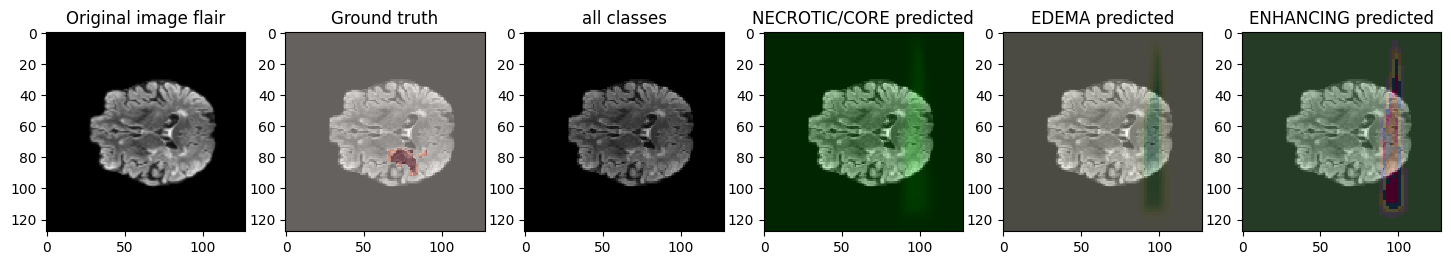

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

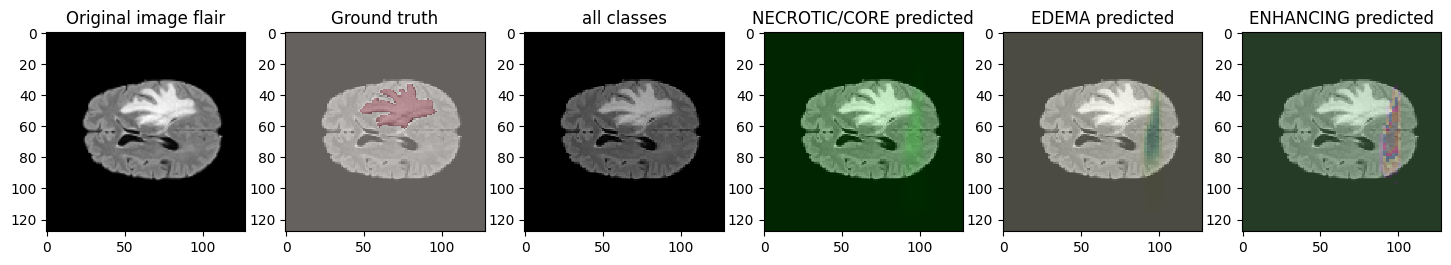

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

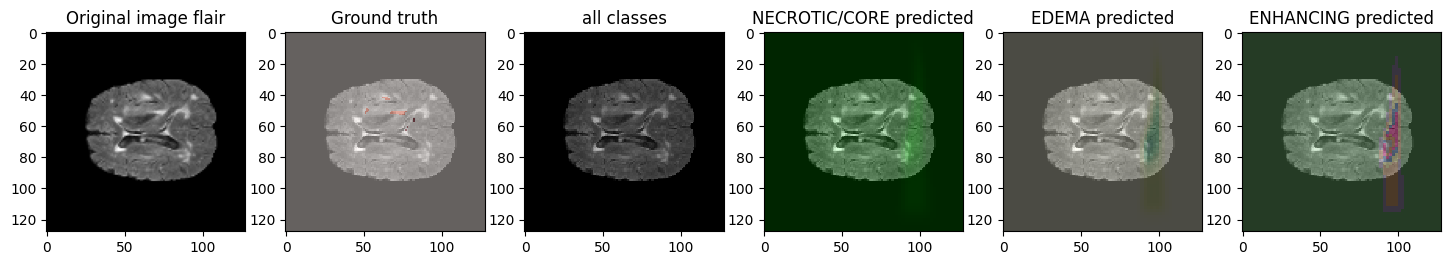

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

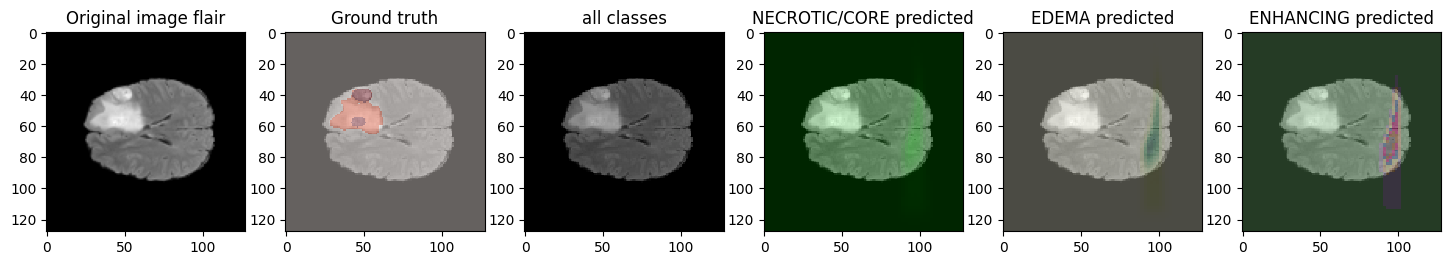

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

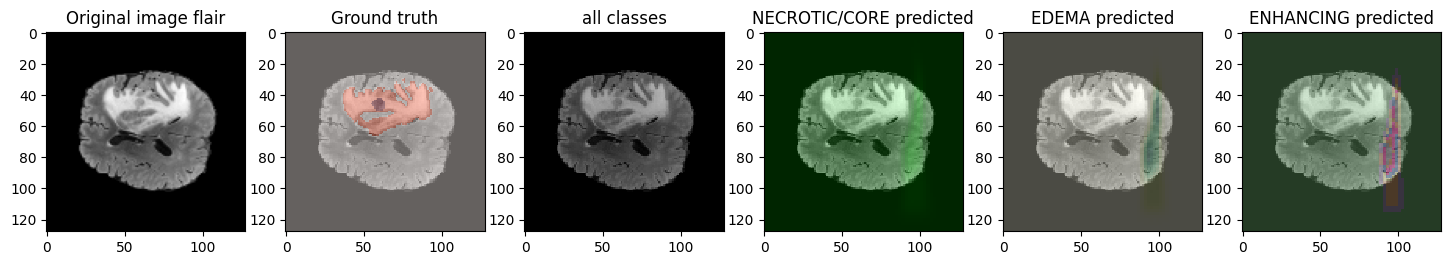

4/4 [==============================] - 0s 25ms/step


<Figure size 1800x5000 with 0 Axes>

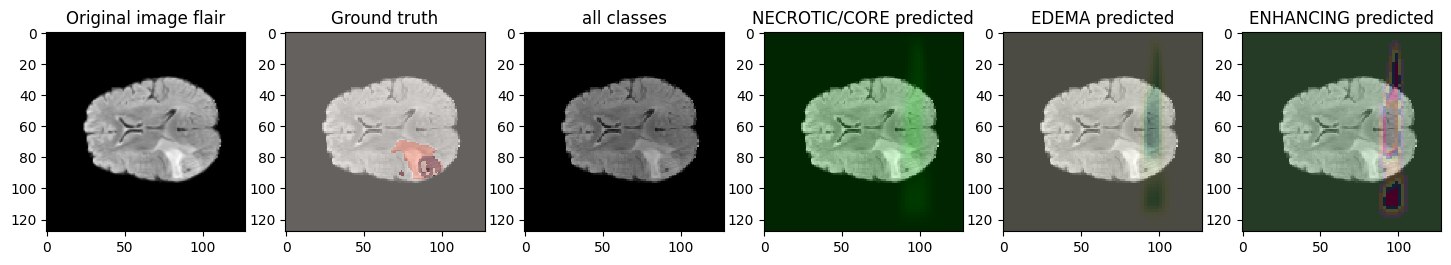

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

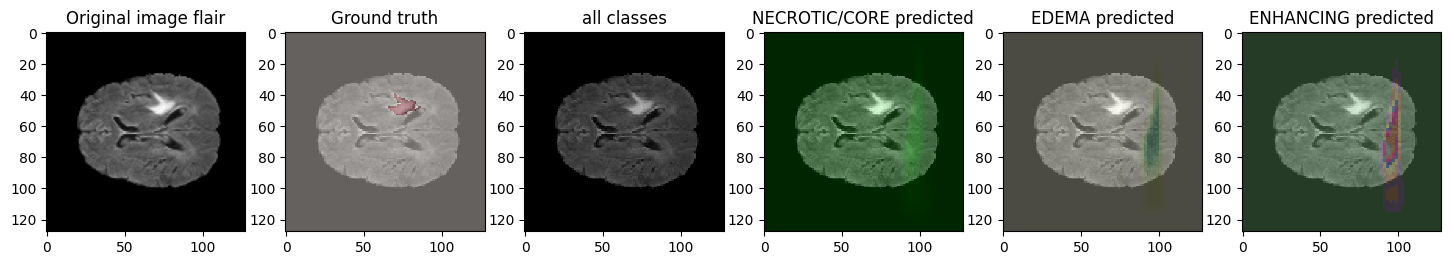

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

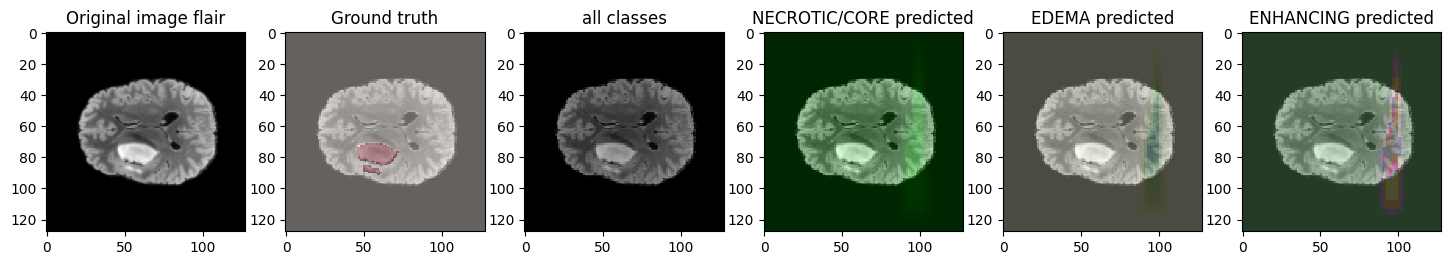

4/4 [==============================] - 0s 24ms/step


<Figure size 1800x5000 with 0 Axes>

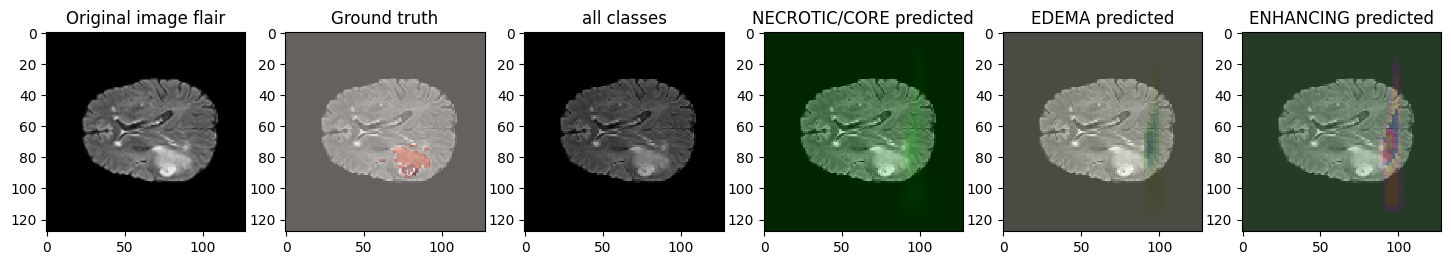

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

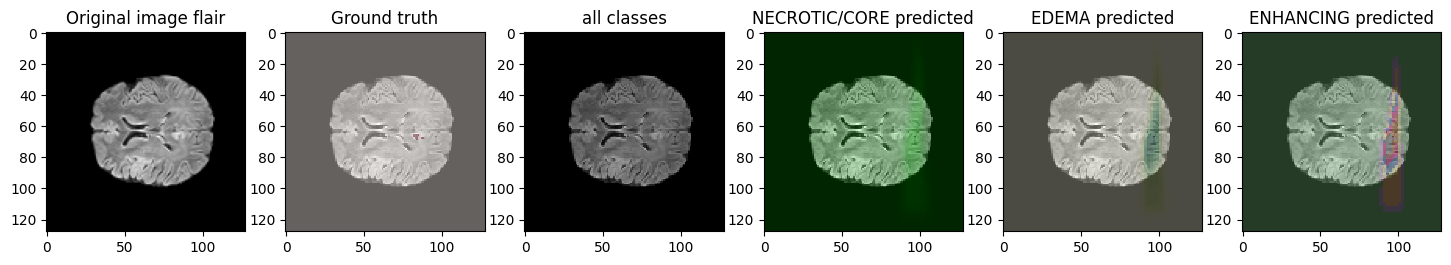

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

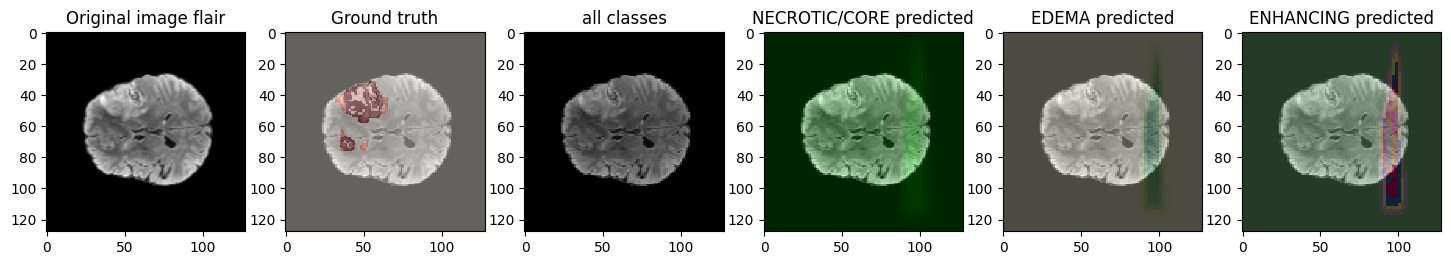

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

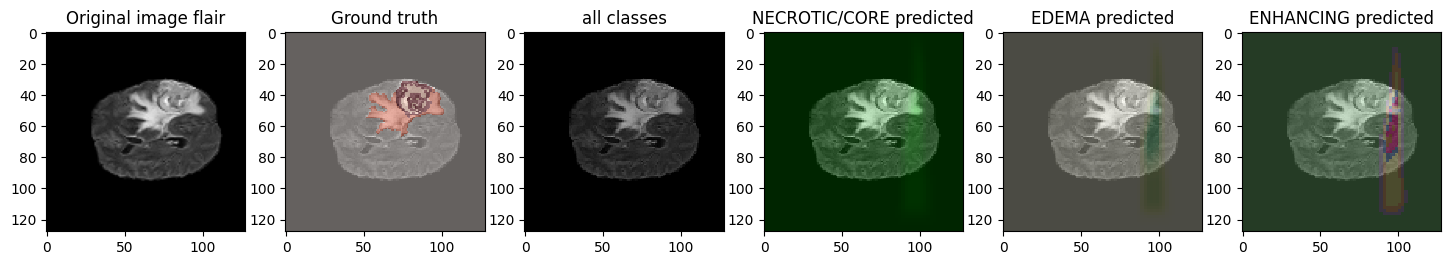

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

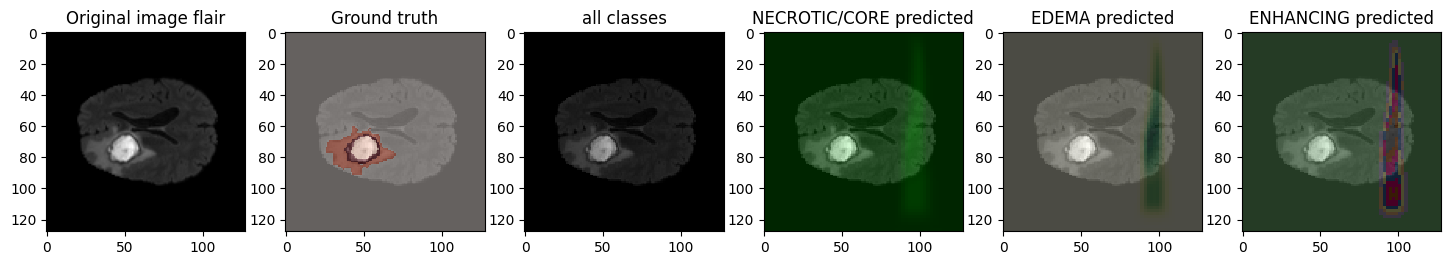

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

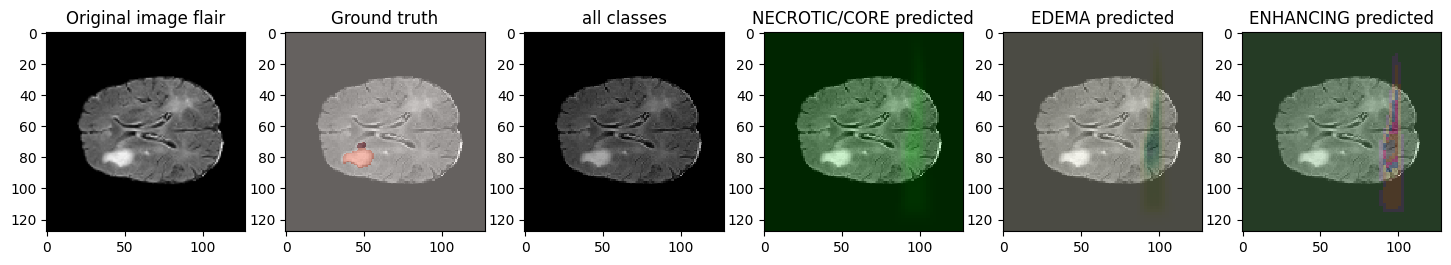

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

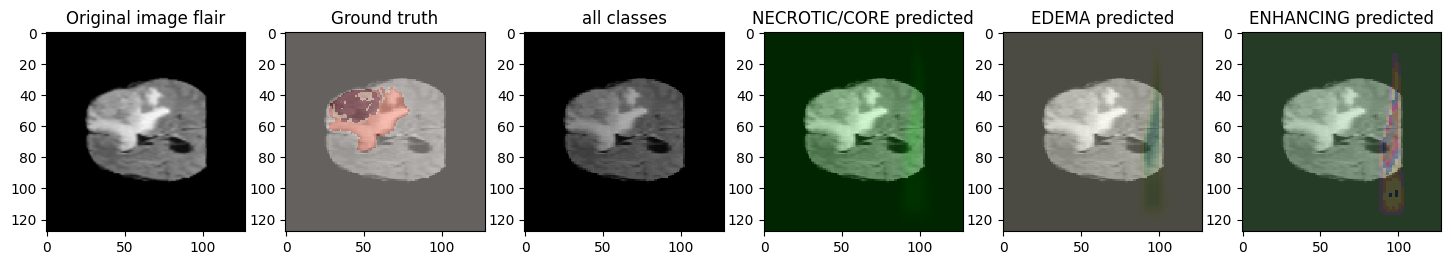

4/4 [==============================] - 0s 23ms/step


<Figure size 1800x5000 with 0 Axes>

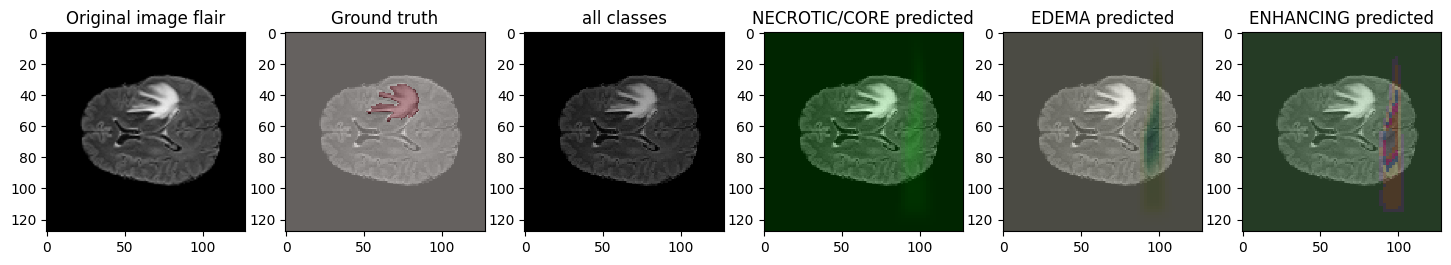

In [111]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

   # /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    vol_path = case_path + case + '_flair.nii.gz';
    flair=nib.load(vol_path).get_fdata()
    
    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    vol_path = case_path + case + '_t1ce.nii.gz';
    ce=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

def showPredictsById(case, start_slice = 60):
    path = TRAIN_DATASET_PATH + case + '/'

    # TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

    gt = nib.load(path + case +'_seg.nii.gz').get_fdata()
    origImage = nib.load(path + case +'_flair.nii.gz').get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.4) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,1:4], cmap="Blues", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="green_transparent", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="YlGn", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="Accent", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])
showPredictsById(case=test_ids[7])
showPredictsById(case=test_ids[8])
showPredictsById(case=test_ids[9])
showPredictsById(case=test_ids[10])
showPredictsById(case=test_ids[11])
showPredictsById(case=test_ids[12])
showPredictsById(case=test_ids[13])
showPredictsById(case=test_ids[14])
showPredictsById(case=test_ids[15])